# Lab 6: Interactive geospatial analysis in a SageMaker AI Studio JupyterLab notebook using a custom SageMaker Distribution Image

This notebook is based on this [notebook](https://github.com/aws-samples/sagemaker-custom-image-for-geospatial-analytics/blob/main/notebooks/01-interactive-geospatial-analyses-custom-image.ipynb) but adapted and extended for a specialized workshop.

<div class="alert alert-info"><b>Prerequsites:</b> You need to build and attach a custom SageMaker image by executing the <code>custom-sm-image/build_sm_custom_image.ipynb</code> notebook. <br/>After you executed the image build notebook and attach the custom image to the domain, open Lab 6 notebook in <b>a new JupyterLab app</b> and make sure to select the custom image you built and attached.
</div>

## Install packages

If you use a custom SageMaker image, you don't need to install packages because they are integrated in the custom image.

In [2]:
# %pip install pandas
# %pip install numpy
# %pip install geopandas
# %pip install shapely
# %pip install matplotlib
# %pip install plotly_express
# %pip install sentinelhub[AWS]
# %pip install rasterio
# %pip install leafmap
# %pip install rioxarray
# %pip install earthpy
# %pip install folium
# %pip install scooby box

## Import Geospatial Libraries

In [1]:
# geo libraries
import geopandas as gpd
import pandas as pd
import pystac_client
import shapely
from shapely import geometry, wkt
import leafmap
import rasterio
from rasterio.plot import show
import rioxarray

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

## Define an exemplary geometry

In [3]:
coords = [[-102.00723310488662,40.596123257503024],[-102.00723310488662,40.58168585757733],[-101.9882214495914,40.58168585757733],[-101.9882214495914,40.596123257503024],[-102.00723310488662,40.596123257503024]]
polgyon = shapely.Polygon(coords)
aoi_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polgyon])

## Visualize the geometry

In [4]:
Map = leafmap.Map(center=[40.596123257503024, -102.00723310488662], zoom=13)
Map.add_basemap("USGS NAIP Imagery")
Map.add_gdf(aoi_gdf, layer_name="test", style={"color": "yellow", "fillOpacity": 0.3, "clickable": True,})
Map

Map(center=[40.596123257503024, -102.00723310488662], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Search Sentinel-2 Satellite Data for given geometry

In [5]:
def search_sentinel2_collection(start_date, end_date, aoi_geometry,max_cloud=100):
    """
    Search Sentinel 2 data collection for target_date
    and collect results including meta data in a dictionary.
    This function uses the PySTAC client
    """
    client = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
    collection = "sentinel-2-l2a"
    
    search = client.search(
        collections=[collection],
        query = {"eo:cloud_cover":{"lt":max_cloud}},
        intersects=aoi_geometry.to_crs("EPSG:4326").geometry[0].__geo_interface__, 
        datetime=f"{start_date}/{end_date}"
    )
    
    s2_items = []
    for item in search.items_as_dicts():
        s2_items.append(item)
        
    return s2_items

In [8]:
# setup search parameters
analysis_start_date = pd.to_datetime("2023-07-01T00:00:00Z").date()
analysis_end_date = pd.to_datetime("2023-07-31T00:00:00Z").date()
aoi_geometry = aoi_gdf.geometry
max_cloud = 5

In [7]:
sentinel2_items = search_sentinel2_collection(
    start_date=analysis_start_date,
    end_date=analysis_end_date,
    aoi_geometry = aoi_geometry,
    max_cloud=max_cloud
)

In [8]:
from IPython.display import JSON
JSON(sentinel2_items)

<IPython.core.display.JSON object>

## Inspect a single Sentinel-2 Item by looking at its thumbnail 

It's a low-res Preview of the Sentinel-2 Tile:

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/T/KL/2023/7/S2B_14TKL_20230702_0_L2A/thumbnail.jpg


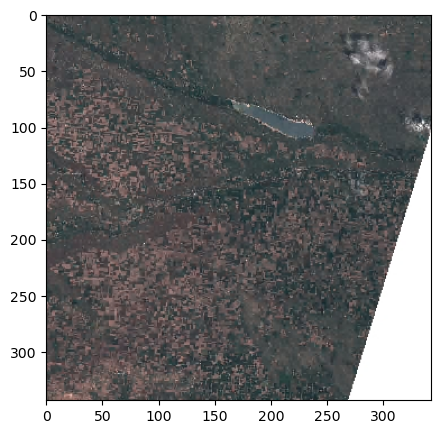

In [9]:
thumbnail_path = sentinel2_items[-1]["assets"]["thumbnail"]["href"]
print(thumbnail_path)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
    src_thumbnail = rasterio.open(thumbnail_path)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
show(src_thumbnail, ax=ax)
plt.show()

## Download selected Sentinel-2 bands 

Download red, green, blue from S3, clip to Area of Observation (AOI) and visualize.

In [10]:
def get_rgb_bands(aoi_geometry, sentinel2_item, output_projection="EPSG:4326"):
    """
    Extract red, green, blue (RGB) bands from GeoTiff,
    reproject to desired CRS and collect in array
    """
    aoi_geometry = aoi_geometry.to_crs(output_projection)[0]
    blue = rioxarray.open_rasterio(sentinel2_items[-1]["assets"]["blue"]["href"], masked=True)
    green = rioxarray.open_rasterio(sentinel2_items[-1]["assets"]["green"]["href"], masked=True)
    red = rioxarray.open_rasterio(sentinel2_items[-1]["assets"]["red"]["href"], masked=True)

    bands = []
    for band in [red, green, blue]:
        kwargs = {"nodata": np.nan}
        band_reprojected = band.rio.reproject(output_projection, **kwargs)
        bands.append(band_reprojected.rio.clip(geometries=[geometry.mapping(aoi_geometry)]))
    return bands

def normalize_rgb_bands(rgb_bands):
    """
    Re-scale/normalize rgb bands to range [0,255]
    """
    bands = []
    for band in rgb_bands:
        img_arr = band.to_numpy()
        normalized = img_arr / np.amax(img_arr)
        normalized = normalized * 255
        bands.append(normalized.astype(np.uint8)[0])
    return np.array(bands)

In [11]:
bands = get_rgb_bands(aoi_geometry=aoi_geometry, sentinel2_item=sentinel2_items[-1], output_projection="EPSG:3857")
bands_norm = normalize_rgb_bands(bands)

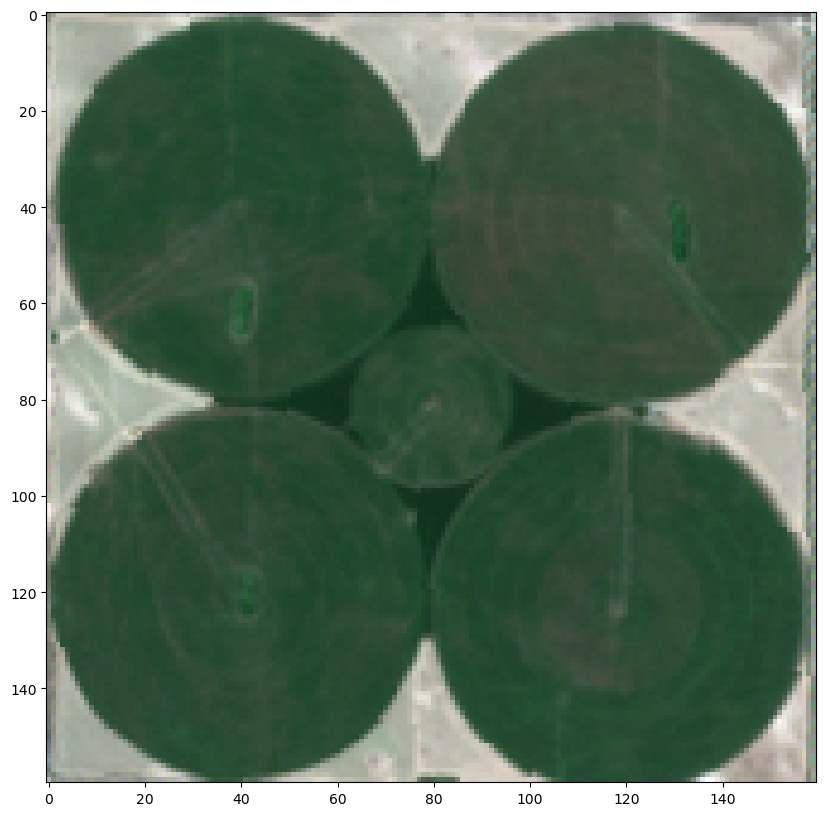

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(bands_norm.transpose(1, 2, 0))
plt.show()